# # 🧠 Taller: *Análisis y Predicción del Consumo Energético con Series Temporales*
#
# **Duración:** 1 hora  
# **Herramientas:** Python (Pandas, Statsmodels, Scikit-learn, Matplotlib)  
# **Objetivo:** aprender a analizar y predecir la demanda eléctrica, comparando modelos clásicos y de *machine learning*, e incorporar costos reales de sobre/subestimación.

In [4]:
# === Librerías base ===
# Instalar si hace falta:
# !pip install numpy pandas matplotlib scikit-learn statsmodels

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)

# ## ⚡ ¿Por qué importa pronosticar la demanda?
#
# > Las empresas de energía deben equilibrar **oferta y demanda** cada hora.  
# > - Si generan o compran de más → pérdidas por venta barata  
# > - Si generan o compran de menos → cortes o energía de emergencia a precios altísimos  
#
# Una buena predicción significa **millones en ahorro operativo** y decisiones informadas sobre cuándo **generar, comprar o vender** energía.
#
# 📈 **Nuestro objetivo hoy:**  
# Usar datos horarios de demanda eléctrica (reales o simulados) para:
# 1. Analizar patrones y estacionalidades.  
# 2. Probar dos métodos predictivos: **ARIMA** vs **Random Forest**.  
# 3. Evaluar errores y **costos asimétricos**.

# ## 🧩 1️⃣ Cargar los datos

In [10]:
# --- Cargar el dataset previamente generado ---
data = pd.read_csv("synthetic_energy_demand_with_covariates.csv", parse_dates=["timestamp"])
data.set_index("timestamp", inplace=True)
data.head()

,subregion,temp_c,humidity_pct,demanda_mwh,hour,dow,month,holiday
timestamp,,,,,,,,
2020-01-01 00:00:00,Norte,11.195193,96.912983,92.021472,0,2,1,1
2020-01-01 01:00:00,Norte,14.859958,86.646666,166.795309,1,2,1,1
2020-01-01 02:00:00,Norte,15.824377,86.669321,191.872985,2,2,1,1
2020-01-01 03:00:00,Norte,18.501837,76.085419,212.770663,3,2,1,1
2020-01-01 04:00:00,Norte,16.621752,77.909265,218.678552,4,2,1,1


In [12]:
# Información general del dataset
print(data.info())
print("\nRango de fechas:", data.index.min(), "→", data.index.max())
print("\nSubregiones disponibles:", data["subregion"].unique())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 131400 entries, 2020-01-01 00:00:00 to 2022-12-30 23:00:00
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   subregion     131400 non-null  object 
 1   temp_c        131400 non-null  float64
 2   humidity_pct  131400 non-null  float64
 3   demanda_mwh   131400 non-null  float64
 4   hour          131400 non-null  int64  
 5   dow           131400 non-null  int64  
 6   month         131400 non-null  int64  
 7   holiday       131400 non-null  int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 9.0+ MB
None

Rango de fechas: 2020-01-01 00:00:00 → 2022-12-30 23:00:00

Subregiones disponibles: ['Norte' 'Centro' 'Sur' 'Occidente' 'Oriente']


# ## 🔍 2️⃣ Exploración de Datos (EDA)
#
# Vamos a explorar cómo varía la demanda eléctrica a lo largo del tiempo.
#
# ### Ejemplo: Demanda promedio por mes
# Agrupemos la demanda promedio mensual por subregión para identificar patrones estacionales.

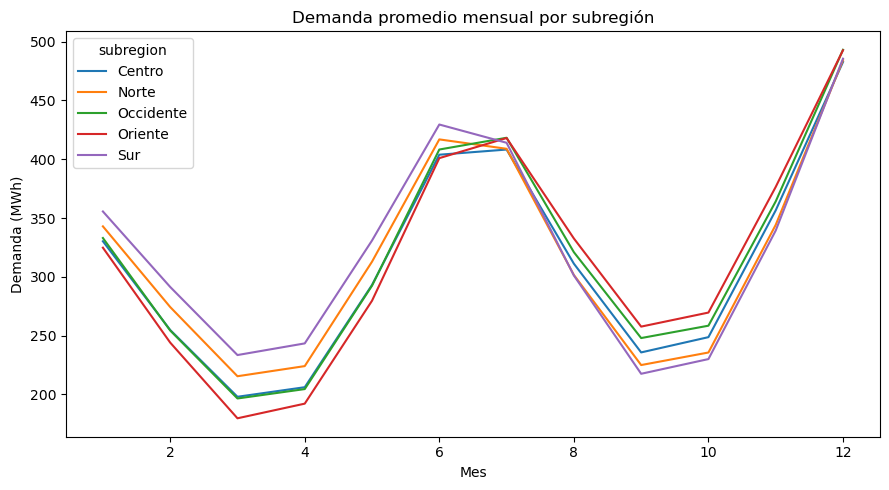

In [16]:
# --- Perfil mensual promedio ---
fig, ax = plt.subplots(figsize=(9, 5))
tmp_month = data.groupby(["subregion", data.index.month])["demanda_mwh"].mean().unstack(0)
tmp_month.plot(ax=ax)
ax.set_title("Demanda promedio mensual por subregión")
ax.set_xlabel("Mes")
ax.set_ylabel("Demanda (MWh)")
plt.tight_layout()
plt.show()

# 👀 **Observación:**  
# Se nota un patrón estacional: algunos meses (por ejemplo, verano o invierno) presentan una mayor demanda según la región.
#
# ---
#
# ### 🧩 Ejercicio para la audiencia
#
# 💭 **Pregunta:**  
# ¿Qué pasaría si en lugar de agrupar por *mes*, agrupamos por *día de la semana*?
#
# 👉 **Tu turno:** agrupa los datos para calcular la demanda promedio por día de la semana (0=Lunes, 6=Domingo) y genera un gráfico similar al anterior.
#
# *(Tómate un momento para pensar cómo cambiarías el código...)*


# ### ✅ Solución
#
# En lugar de `data.index.month`, podemos usar `data.index.dayofweek` (o una columna auxiliar `dow`) para agrupar por día de la semana.

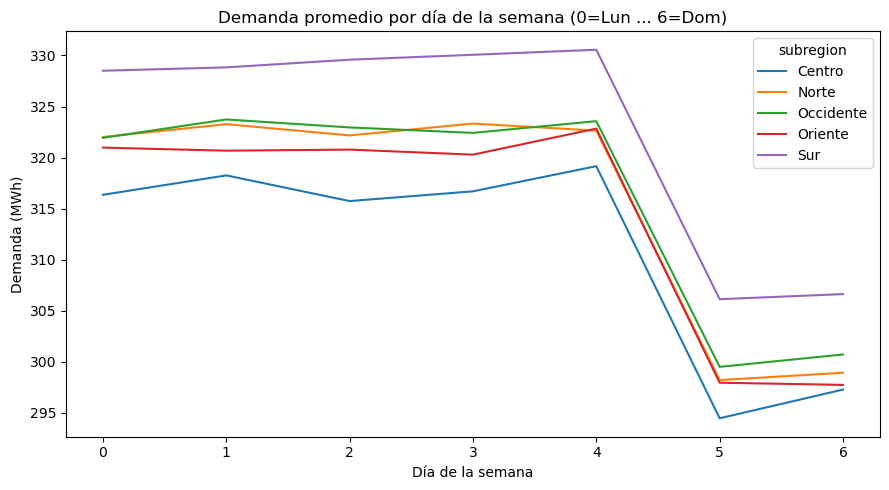

In [22]:
# --- Solución: Demanda promedio por día de la semana ---
fig, ax = plt.subplots(figsize=(9, 5))
tmp_dow = (data
           .assign(dow=data.index.dayofweek)
           .groupby(["subregion", "dow"])["demanda_mwh"]
           .mean()
           .unstack(0))
tmp_dow.plot(ax=ax)
ax.set_title("Demanda promedio por día de la semana (0=Lun ... 6=Dom)")
ax.set_xlabel("Día de la semana")
ax.set_ylabel("Demanda (MWh)")
plt.tight_layout()
plt.show()

# 💡 **Conclusión del ejercicio:**  
# El patrón semanal suele mostrar menor consumo durante los fines de semana (días 5 y 6), cuando la actividad industrial disminuye.
#
# 👉 Esta variación es importante al construir modelos, porque nos indica que debemos incluir la variable `day_of_week` o `dow` como **covariable temporal**.

In [ ]:
# --- Perfil diario promedio ---
fig, ax = plt.subplots(figsize=(9, 5))
tmp = data.groupby(["subregion", data.index.hour])["demanda_mwh"].mean().unstack(0)
tmp.plot(ax=ax)
ax.set_title("Perfil diario promedio por subregión")
ax.set_xlabel("Hora del día")
ax.set_ylabel("Demanda (MWh)")
plt.tight_layout()
plt.show()

# --- Patrón semanal promedio ---
fig, ax = plt.subplots(figsize=(9, 5))
tmp2 = (data.assign(dow=data.index.dayofweek)
        .groupby(["subregion", "dow"])["demanda_mwh"]
        .mean().unstack(0))
tmp2.plot(ax=ax)
ax.set_title("Patrón semanal promedio (0=Lun ... 6=Dom)")
ax.set_xlabel("Día de la semana")
ax.set_ylabel("Demanda (MWh)")
plt.tight_layout()
plt.show()

# %% [markdown]
# ## 🤖 3️⃣ Modelos para pronosticar
#
# ### 🔹 Modelo SARIMAX (clásico de series temporales)
# Captura estacionalidad y depende del histórico de la misma variable.  
# 
# ### 🔹 Random Forest (machine learning)
# Usa variables de calendario, temperatura y rezagos.  
# Escala bien a muchas subregiones.

# %%
# --- SARIMAX: entrenar en una subregión ---
sr_ejemplo = "Centro"
df_sr = data.loc[data["subregion"] == sr_ejemplo, ["demanda_mwh", "temp_c"]].copy()

test_horas = 24 * 60
y = df_sr["demanda_mwh"]
exog = df_sr[["temp_c"]]
y_train, y_test = y.iloc[:-test_horas], y.iloc[-test_horas:]
X_train, X_test = exog.iloc[:-test_horas], exog.iloc[-test_horas:]

sarimax = SARIMAX(y_train, exog=X_train, order=(1, 0, 1), seasonal_order=(1, 1, 1, 24))
res = sarimax.fit(disp=False)
pred_sarimax = res.predict(start=y_test.index[0], end=y_test.index[-1], exog=X_test)

fig, ax = plt.subplots(figsize=(10, 4))
y_test.plot(ax=ax, label="Real", linewidth=1)
pred_sarimax.plot(ax=ax, label="SARIMAX", linewidth=1)
ax.set_title(f"{sr_ejemplo}: Pronóstico SARIMAX")
ax.legend()
plt.tight_layout()
plt.show()

# %%
# --- Random Forest: entrenamiento en todas las subregiones ---
def add_time_features(df):
    out = df.copy()
    out["hour"] = out.index.hour
    out["dow"] = out.index.dayofweek
    out["month"] = out.index.month
    return out

def add_lags(df, target_col="demanda_mwh", lags=(1, 2, 24, 48, 168)):
    out = df.copy()
    for L in lags:
        out[f"{target_col}_lag{L}"] = out[target_col].shift(L)
    return out

panel = data.copy()
panel = panel.groupby("subregion", group_keys=False).apply(add_time_features)
panel = panel.groupby("subregion", group_keys=False).apply(add_lags)
panel = panel.dropna()

cut_idx = panel.index.get_level_values(1).max() - pd.Timedelta(hours=test_horas)
train = panel.loc[(panel.index.get_level_values(1) <= cut_idx)]
test  = panel.loc[(panel.index.get_level_values(1) >  cut_idx)]

features = [c for c in panel.columns if c != "demanda_mwh"]
Xtr, Xte = train[features], test[features]
ytr, yte = train["demanda_mwh"], test["demanda_mwh"]

rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(Xtr, ytr)
pred_rf = rf.predict(Xte)

mask_sr = test.reset_index()["subregion"] == sr_ejemplo
yte_sr = yte[mask_sr.values]
prf_sr = pd.Series(pred_rf[mask_sr.values], index=yte_sr.index)

fig, ax = plt.subplots(figsize=(10, 4))
yte_sr.iloc[:24*14].plot(ax=ax, label="Real", linewidth=1)
prf_sr.iloc[:24*14].plot(ax=ax, label="Random Forest", linewidth=1)
ax.set_title(f"{sr_ejemplo}: Random Forest (2 semanas)")
ax.legend()
plt.tight_layout()
plt.show()

# %% [markdown]
# ## 📏 4️⃣ Métricas de Evaluación

# %%
def mape(y_true, y_pred, eps=1e-6):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.maximum(eps, np.abs(y_true)))) * 100

rmse_sar = mean_squared_error(y_test, pred_sarimax, squared=False)
mae_sar  = mean_absolute_error(y_test, pred_sarimax)
mape_sar = mape(y_test, pred_sarimax)

rmse_rf = mean_squared_error(yte, pred_rf, squared=False)
mae_rf  = mean_absolute_error(yte, pred_rf)
mape_rf = mape(yte, pred_rf)

pd.DataFrame({
    "Modelo": ["SARIMAX (1 SR)", "Random Forest (todas SR)"],
    "RMSE": [rmse_sar, rmse_rf],
    "MAE": [mae_sar, mae_rf],
    "MAPE (%)": [mape_sar, mape_rf]
})

# %% [markdown]
# ## 💸 5️⃣ Costo asimétrico de errores

# %%
P_sell = 10
P_buy = 200

def asymmetric_cost(y_true, y_pred, p_sell=P_sell, p_buy=P_buy):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    over = np.clip(y_pred - y_true, 0, None)
    under = np.clip(y_true - y_pred, 0, None)
    return np.sum(over * p_sell + under * p_buy)

cost_sar = asymmetric_cost(y_test.values, pred_sarimax.values)
cost_rf = asymmetric_cost(yte.values, pred_rf)

pd.DataFrame({
    "Modelo": ["SARIMAX", "Random Forest"],
    "Costo_asim_total": [cost_sar, cost_rf]
})

# %% [markdown]
# ## 🎯 6️⃣ Ajuste por bias óptimo

# %%
def find_best_bias(y_true, y_pred, p_sell=P_sell, p_buy=P_buy, grid=np.linspace(-30, 30, 121)):
    best_b, best_c = None, np.inf
    for b in grid:
        c = asymmetric_cost(y_true, y_pred + b, p_sell, p_buy)
        if c < best_c:
            best_c, best_b = c, b
    return best_b, best_c

b_sar, c_sar = find_best_bias(y_test.values, pred_sarimax.values)
b_rf, c_rf = find_best_bias(yte.values, pred_rf)

pd.DataFrame({
    "Modelo": ["SARIMAX", "Random Forest"],
    "Bias_óptimo (MWh)": [b_sar, b_rf],
    "Costo_asim_con_bias": [c_sar, c_rf]
})

# %%
fig, ax = plt.subplots(figsize=(10, 4))
(y_test - pred_sarimax).rolling(24).mean().plot(ax=ax, label="Error rolling (sin bias)")
(y_test - (pred_sarimax + b_sar)).rolling(24).mean().plot(ax=ax, label=f"Error rolling (con bias={b_sar:.1f})")
ax.axhline(0, linestyle="--", color="gray")
ax.legend()
ax.set_title(f"{sr_ejemplo}: Impacto del bias óptimo en el error promedio")
plt.tight_layout()
plt.show()
